In [1]:
import fcsparser
import glob
import numpy as np
import scipy 
import gudhi as gd
from scipy.stats import gaussian_kde as kde


import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set(style = "whitegrid")
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 7]

In [2]:
paths = glob.glob(r"C:\Users\adsmith23\ML\1-Skeleton\Flow_Cytometry\*.fcs")

densities = []
samples = []

for i in range(len(paths)):
    path = paths[i]
    meta, data = fcsparser.parse(path, reformat_meta=True)
    sample = np.asarray(data[["APC-A","FITC-A"]])
    sample = sample[sample.min(axis=1)>=0,:]
    samplelog = np.stack([np.log10(sample[:,0]+1),np.log10(sample[:,1]+1)])
    xmin = .5
    xmax = 6
    ymin = .5
    ymax = 6
    X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = samplelog
    kernel = kde(values, bw_method = 0.45)
    Z = np.reshape(kernel(positions).T, X.shape)
    densities.append(Z)
    samples.append(samplelog)

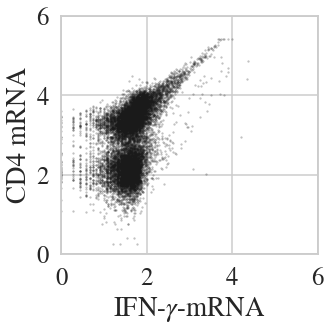

In [3]:
fig = plt.figure(figsize = (5,5))
plt.scatter(samples[0][1,:],samples[0][0,:],.5,alpha = .3,c = 'k')
plt.xlim([0,6])
plt.ylim([0,6])
plt.xlabel(r"IFN-$\gamma$-mRNA")
plt.ylabel(r"CD4 mRNA")
plt.tight_layout()
plt.savefig("fct0.pdf")


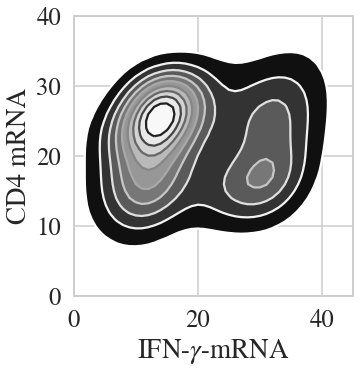

In [8]:
plt.figure(figsize = (5,5))
plt.contour(densities[4],np.linspace(.02,np.max(densities[4]),10),cmap = "Greys")
plt.contourf(densities[4],np.linspace(.02,np.max(densities[4]),10),cmap = 'Greys_r', extend = 'max')
plt.tight_layout()
plt.ylim([0,40])
plt.xlim([0,45])

plt.xlabel("IFN-$\gamma$-mRNA")
plt.ylabel("CD4 mRNA")

plt.savefig("cont_4.svg")



AttributeError: 'Poly3DCollection' object has no property 'origin'

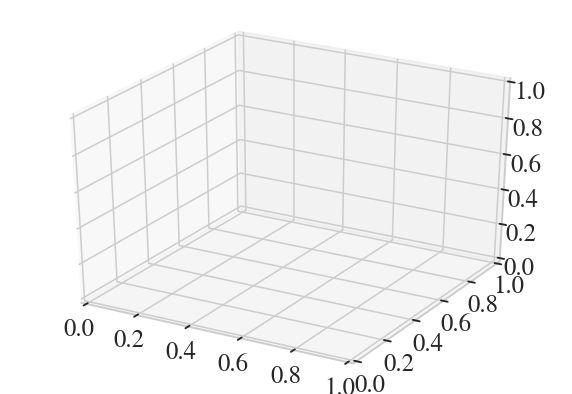

In [134]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X,Y,densities[3],cmap = "Greys_r",linewidth = 0)
plt.setp( ax.get_xticklabels(), visible=False)
plt.setp( ax.get_yticklabels(), visible=False)
plt.gca().set_zticks([0,.1,.2,.3])
plt.xlabel(r"IFN-$\gamma$-mRNA")
plt.ylabel(r"CD4 mRNA")
plt.tight_layout()
plt.savefig('fct_surf.svg')

In [5]:
# define filtration range and increments
numPoints = 200;
filtrationStart = 0;
filtrationEnd = 1;
filtrations = np.linspace(filtrationStart,filtrationEnd,numPoints);

# function returns an euler characteristic curve for a given image
def getEC(data):
    cubeplex = gd.CubicalComplex(dimensions  = [np.shape(data)[0],np.shape(data)[1]],top_dimensional_cells=np.ndarray.flatten(data));
    cubeplex.compute_persistence();
    b = np.zeros( (numPoints,2) ) ;
    ec = np.zeros(numPoints);
    for (i,fval) in enumerate((filtrations)):
        betti = cubeplex.persistent_betti_numbers(fval,fval);
        b[i] = [betti[0], betti[1]];
        ec[i] = betti[0] - betti[1];
    return ec;

In [6]:
ecs =[]
for i in densities:
    ecs.append(getEC(i))

In [7]:
dists = []

for i in range(5):
    dist = np.sum(np.sqrt((ecs[i] - ecs[0])**2))
    dists.append(dist)

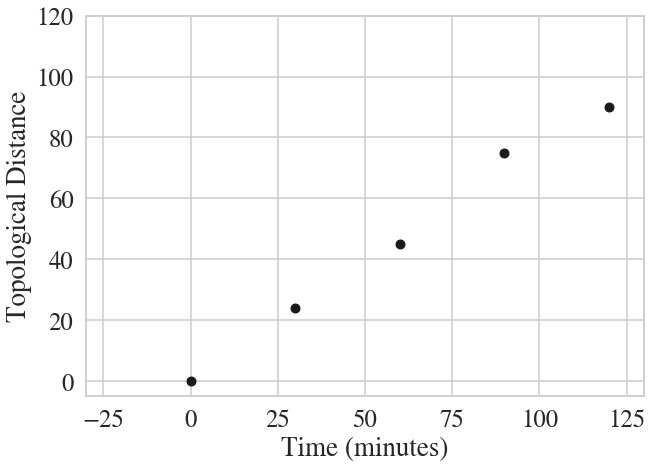

In [88]:
plt.plot([0,30,60,90,120],dists,'o',c = 'k')
plt.ylabel("Topological Distance")
plt.xlabel("Time (minutes)")
plt.xlim([-30,130])
plt.ylim([-5,120])
plt.savefig("cyto_over_time_betti1.svg")